# Experiment 1: Intelligent Image Classification and Visual Analytics Platform

## Aim
To build an image classification system using deep learning and visualize model performance through analytical dashboards with an automated MLOps pipeline.

## Tasks
- Implement CNN for image classification
- Plot accuracy, loss, confusion matrix
- Track experiments using MLflow
- Dockerize and deploy the model

## 1. Dataset & Problem Setup


In [ ]:
!pip install mlflow fastapi uvicorn pyngrok nest_asyncio pyarrow seaborn matplotlib tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Install dependencies
pip install -r requirements.txt

# Run the dashboard
streamlit run dashboard.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import mlflow
import mlflow.tensorflow
import pickle
import os

# Function to load CIFAR-10 from local batches
def load_cifar10_data(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    train_data = []
    train_labels = []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        batch = unpickle(batch_file)
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])

    X_train = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_train = np.array(train_labels)

    test_batch = unpickle(os.path.join(data_dir, 'test_batch'))
    X_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_batch[b'labels'])

    return (X_train, y_train), (X_test, y_test)

# Load Data
data_dir = '../data/cifar-10-batches-py'
print(f"Loading data from: {os.path.abspath(data_dir)}")
(X_train, y_train), (X_test, y_test) = load_cifar10_data(data_dir)

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# Class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Loading data from: e:\LP 2\Experiment 1 Image classification\data\cifar-10-batches-py


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22988\4243718908.py:19: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  dict = pickle.load(fo, encoding='bytes')


Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


## 2. Model Implementation (CNN)
We use a VGG-style CNN with Data Augmentation, Batch Normalization, and Dropout.

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

def create_model():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        # Block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        # Block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),

        # Dense Layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 552,874 (2.11 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

## 3. Training & Evaluation with MLflow
We log parameters and metrics to MLflow and use EarlyStopping callbacks.

In [ ]:
mlflow.set_experiment("CIFAR10_Image_Classification_Lab")

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

with mlflow.start_run():
    # Log parameters
    epochs = 30 # Reduced for lab demonstration speed, aim for 50 if GPU available
    batch_size = 64
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("model_type", "CNN_VGG_Style")

    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Log metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)
    
    # Log the model
    mlflow.tensorflow.log_model(model, "model")

    print("Training Complete & Logged to MLflow")

2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/16 02:36:04 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/16 02:36:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/16 02:36:05 INFO mlflow.store.db.utils: Updating database tables
2026/02/16 02:36:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/16 02:36:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/16 02:36:05 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/02/16 02:3

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 194ms/step - accuracy: 0.3996 - loss: 1.7396 - val_accuracy: 0.4565 - val_loss: 1.6724 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 131s 167ms/step - accuracy: 0.5553 - loss: 1.2411 - val_accuracy: 0.5709 - val_loss: 1.2740 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 144s 185ms/step - accuracy: 0.6278 - loss: 1.0578 - val_accuracy: 0.6042 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.6709 - loss: 0.9471 - val_accuracy: 0.7242 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 185ms/step - accuracy: 0.6959 - loss: 0.8705 - val_accuracy: 0.7192 - val_loss: 0.8211 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - accuracy: 0.7200 - loss: 0.8146 - val_accuracy: 0.7503 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 181ms/step - accura

2026/02/16 03:49:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/16 03:49:47 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Training Complete & Logged to MLflow


## 4. Visual Analytics (Performance Plots)

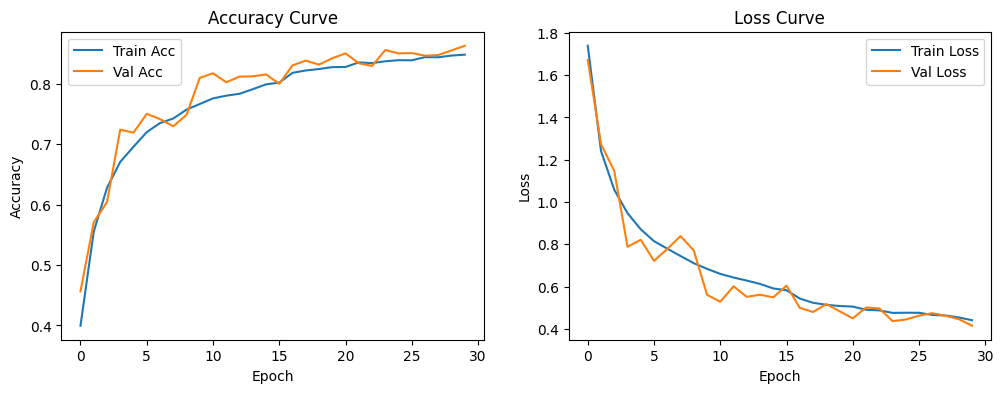

In [ ]:
# Accuracy & Loss Curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


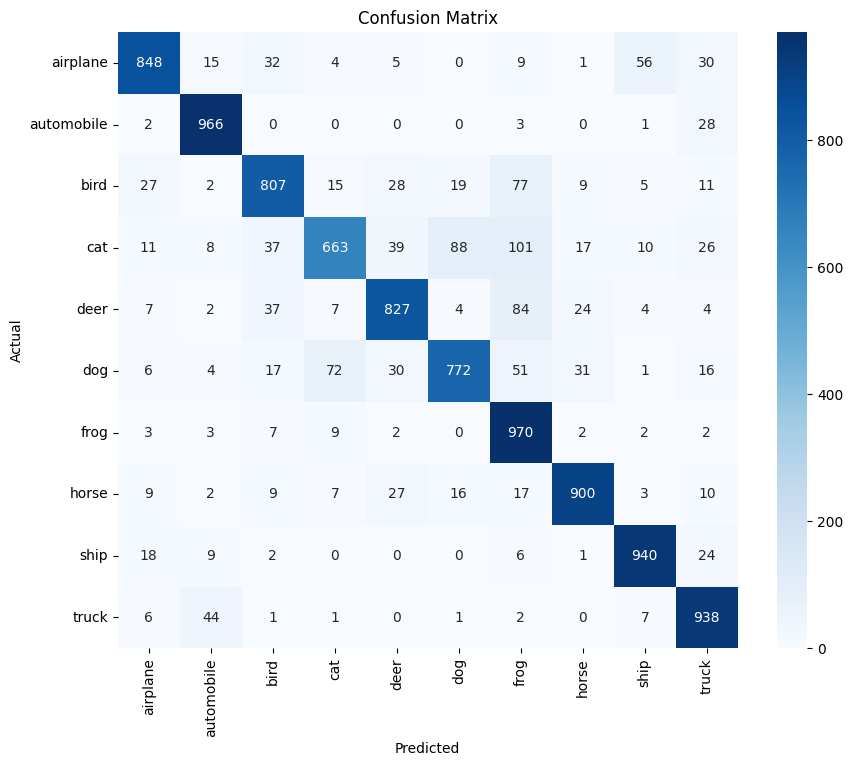

In [ ]:
# Confusion Matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 6. Save Model for Deployment
Saving the model in H5 format for the FastAPI application.

In [ ]:
import os
os.makedirs("../model", exist_ok=True)
model.save("../model/image_classifier.h5")
print("Model saved to ../model/image_classifier.h5")

Model saved to ../model/image_classifier.h5


In [ ]:
python export_metrics_for_powerbi.py
